In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import decimal
import math

In [2]:
spy = yf.Ticker('spy')
spy
decimal.getcontext().prec = 64

In [16]:
spy_historial = spy.history(start="2024-10-02", end="2024-10-3", interval="1m")
spy_historial

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Datetime,,,,,,,,
2024-10-02 09:30:00-04:00,567.710022,567.760010,566.979980,567.030029,1037924,0.0,0.0,0.0
2024-10-02 09:31:00-04:00,566.979980,567.039978,566.500000,566.989990,241030,0.0,0.0,0.0
2024-10-02 09:32:00-04:00,566.979980,567.200012,566.809998,566.989990,120981,0.0,0.0,0.0
2024-10-02 09:33:00-04:00,566.969971,566.969971,566.630005,566.760010,145872,0.0,0.0,0.0
2024-10-02 09:34:00-04:00,566.719971,566.820007,566.599976,566.794983,107198,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-10-02 15:55:00-04:00,569.020020,569.039978,568.909973,568.909973,179580,0.0,0.0,0.0
2024-10-02 15:56:00-04:00,568.900024,569.049988,568.840027,568.880005,216588,0.0,0.0,0.0
2024-10-02 15:57:00-04:00,568.880005,569.049988,568.880005,568.989990,308375,0.0,0.0,0.0


In [4]:
ema_12 = spy_historial["Close"].ewm(span = 12, adjust=False).mean()
ema_26 = spy_historial["Close"].ewm(span = 26, adjust=False).mean()

# macd line
macd = ema_12 - ema_26
# signal line                       
signal = macd.ewm(span=9, adjust=False).mean()

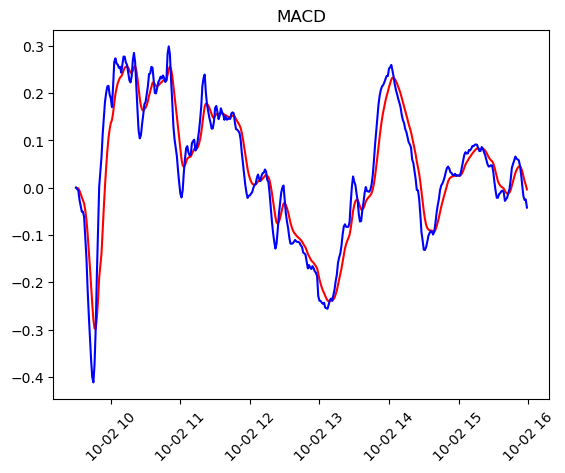

In [5]:
# plotting the MACD indicator for the entire day
plt.plot(spy_historial.index, signal.values, color="red")
plt.plot(spy_historial.index, macd.values, color="blue")
plt.title("MACD")
plt.xticks(rotation=45)
plt.show()

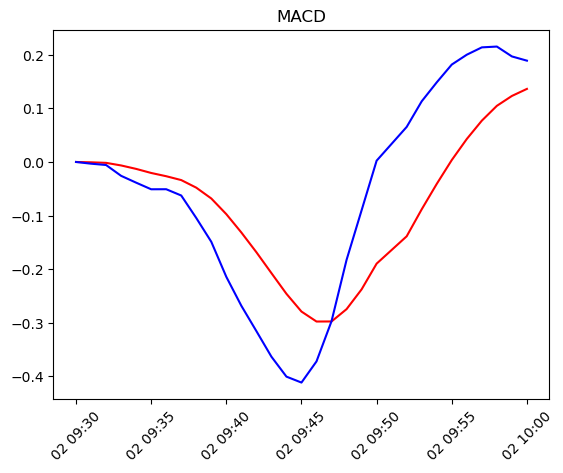

In [6]:
# plotting only 30 minutes
plt.plot(signal.index[:30], signal.values[:30], color="red")
plt.plot(macd.index[:30], macd.values[:30], color="blue")
plt.title("MACD")
plt.xticks(rotation=45)
plt.show()

In [7]:
def get_MACD():
    ema_12 = spy_historial["Open"].ewm(span=12, adjust=False).mean()
    ema_26 = spy_historial["Open"].ewm(span=26, adjust=False).mean()

    # macd line
    macd = ema_12 - ema_26
    # signal line
    signal = macd.ewm(span=9, adjust=False).mean()

    return macd, signal

In [8]:
def long_spy(invest_price, current_price):
    shares = invest_price / current_price
    return shares

In [9]:
# test
print(signal.values[:10])
print(macd.values[:10])
print(type(macd.values[30]))

[ 0.         -0.0006388  -0.00164304 -0.00648916 -0.01291647 -0.02052646
 -0.02659741 -0.03379825 -0.04795336 -0.06816821]
[ 0.         -0.003194   -0.00566002 -0.02587361 -0.03862573 -0.05096641
 -0.05088121 -0.06260162 -0.10457378 -0.14902762]
<class 'numpy.float64'>


In [14]:
# open price at each minute
# every number into decimal object
idx = 0
macd, signal = get_MACD()
invest_price = 1000.0
final_profit = 0.0
shares = 0.0
strike_price = 0.0
profits = []
hold = False # initially we do not hold the stock
buy_time = []
sell_time =[]


for _, row in spy_historial.iterrows():
    #current_price = round(row['Open'], 2)
    current_price = row['Open']
    curr_macd = macd.iloc[idx]
    curr_signal = signal.iloc[idx]
    
    # macd just cross the signal line
    if curr_macd > curr_signal:
        if not hold: # do not currently hold a stock
            shares = long_spy(invest_price, current_price)
            strike_price = current_price
            hold = True
            buy_time.append(current_price)
            sell_time.append(np.nan)
        else:
            buy_time.append(np.nan)
            sell_time.append(np.nan)
    # macd dip below signal line
    elif curr_macd < curr_signal:
        if hold: # we have stock
            final_profit += shares * (current_price - strike_price)
            shares = 0.0 # sold all shares
            hold = False
            buy_time.append(np.nan)
            sell_time.append(current_price)
        else:
            buy_time.append(np.nan)
            sell_time.append(np.nan)
    else:
        buy_time.append(np.nan)
        sell_time.append(np.nan)
    profits.append(final_profit)
    # null values, real value represents buy/sell tick

    idx += 1

print(final_profit)
print(f'Growth Rate: {final_profit / invest_price * 100}')

-1.7358655499886235
Growth Rate: -0.17358655499886236


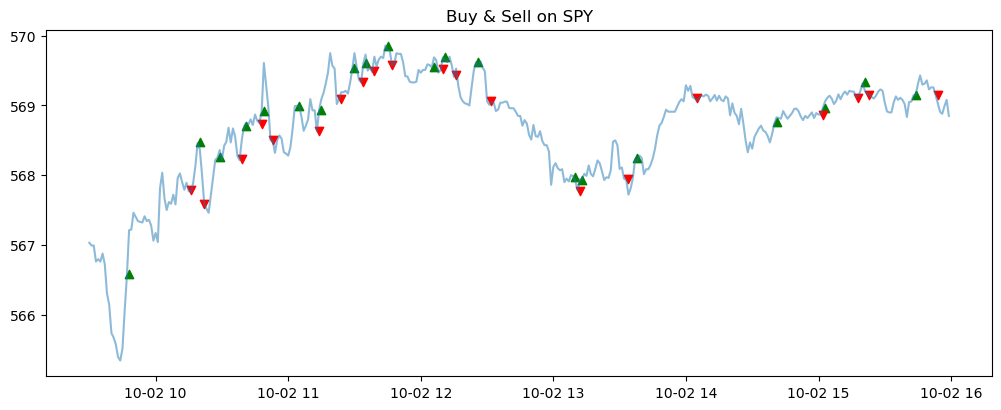

In [11]:
# buy and sell ticks on price history
plt.figure(figsize=(12.2, 4.5))
plt.scatter(spy_historial.index, buy_time, color='green', label='Buy', marker='^')
plt.scatter(spy_historial.index, sell_time,
            color='red', label='Sell', marker='v')
plt.plot(spy_historial['Close'], alpha=0.5)
plt.title("Buy & Sell on SPY")
plt.show()

<Figure size 1220x450 with 0 Axes>

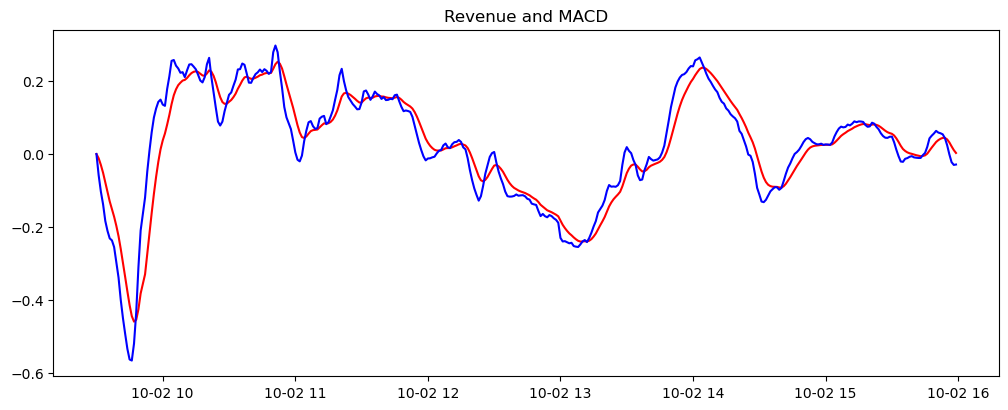

In [12]:
#plt.plot(spy_historial.index, profits, color="green")
plt.figure(figsize=(12.2, 4.5))
plt.figure(figsize=(12.2, 4.5))
plt.plot(signal.index, signal.values, color="red")
plt.plot(macd.index, macd.values, color="blue")
plt.title("Revenue and MACD")
plt.show()

In [13]:
idx = 0
for _, row in spy_historial.iterrows():

    current_price = round(row['Open'], 2)
    curr_macd = macd.iloc[idx]
    curr_signal = signal.iloc[idx]

    print(curr_macd < curr_signal)
    idx += 1

False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
False
False
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
True
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
False
False
False
False
True
False
False
False
False
True
True
True
True
True
True
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
True
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
T